# Multiple Icon Matching in PDF files

The code below takes a multiple pdf files and searches them to find if they contain any matching icons.

Outputs a list of filenames where matches occurred, the template that matched, the page number of the pdf it matched on, and the pixel coordinates needed to draw a rectangle over the match.

One output per match.

Will handle template and pdf icon image size mismatches.

It does not currently count if an icon appears more than once in a pdf page.

[['Copy of Flyer US Letter.pdf', 'oil barrel.png', 1, (627, 1642), (804, 1832)], ['Copy of Flyer US Letter.pdf', 'stars.png', 1, (1339, 130), (1609, 291)]]


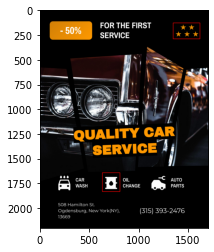

In [2]:
from pdf2image import convert_from_path
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imutils
import os


pdf_files = os.listdir("pdfs")
templates = os.listdir("templates")

threshold = 0.8
page_template_match = []

for pdf in pdf_files:

    pdf_pages = convert_from_path(f"pdfs/{pdf}")
    pdf_images = []
    page_count = 1

    for page in pdf_pages:
        pdf_images.append(np.array(page))

        for template in templates:
            template_image = cv2.imread(f"templates/{template}")

            template_gray = cv2.cvtColor(template_image, cv2.COLOR_BGRA2GRAY)

            (tH, tW) = template_gray.shape[:2]  # template height and width to find X,Y on the pdf image

            found = None  # contain to hold current best match in the image
            page_count = 1

            for im in pdf_images:
                gray_page = cv2.cvtColor(im, cv2.COLOR_BGRA2GRAY)

                for scale in np.linspace(0.2, 1.0, 20)[::-1]:  # start from 100% of the original size of the image and work our way down to 20% of the original size in 20 equally sized percent chunks
                    resized_im = imutils.resize(gray_page, width = int(gray_page.shape[1] * scale))
                    resizing_ratio = gray_page.shape[1] / float(resized_im.shape[1])  # ratio of the resizing

                    if resized_im.shape[0] < tH or resized_im.shape[1] < tW:  # break if smaller than template
                        break

                    result = cv2.matchTemplate(resized_im, template_gray, cv2.TM_CCOEFF_NORMED)
                    # max val is what I need to use as a threshold to see if correct id
                    # (minVal, maxVal, minLoc, maxLoc) = cv2.minMaxLoc(result)

                    (minVal, maxVal, minLoc, maxLoc)  = cv2.minMaxLoc(result)

                    if found is None or maxVal > found[0]:
                        found = (maxVal, maxLoc, resizing_ratio)

                if found[0] > threshold:  # drops the match if it does not exceed the threshold
                    (_, maxLoc, resizing_ratio) = found
                    (startX, startY) = (int(maxLoc[0] * resizing_ratio), int(maxLoc[1] * resizing_ratio))
                    (endX, endY) = (int((maxLoc[0] + tW) * resizing_ratio), int((maxLoc[1] + tH) * resizing_ratio))
                    page_template_match.append([pdf, template, page_count, (startX, startY), (endX, endY) ])
                    cv2.rectangle(pdf_images[0], (startX, startY), (endX, endY), (255, 0, 0), 3)
                    plt.imshow(pdf_images[0])
                found = None
                page_count += 1


print(page_template_match)